# pvlib-python

In [1]:
import utils
import pandas as pd

from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.transform import jitter
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

## ReadTheDocs

In [3]:
df = utils.get_rtd_analytics_data('pvlib')
data_period = df['Date'].min().strftime('%Y-%m-%d') + ' to ' + df['Date'].max().strftime('%Y-%m-%d')

In [4]:
total_by_version = df.groupby('Version')['Views'].sum().reset_index()

p = figure(x_range=total_by_version['Version'], height=350, tooltips=[("Version", "@Version"), ("Views", "@Views")],
           title=f"Page views by RTD version ({data_period})",)
p.vbar(x='Version', top='Views', width=0.75, source=total_by_version,
       line_color='white')
p.xaxis.major_label_orientation = 3.14/2
p.yaxis.axis_label = 'Total page views'
show(p)

In [5]:
daily_views = df.pivot_table(values='Views', index='Date', columns='Version', aggfunc='sum')[['stable', 'latest']].fillna(0)

p = figure(x_axis_type="datetime", height=350, title=f"Daily views by RTD version")
hover_tool = HoverTool(tooltips=[('Date', '@x{%Y-%m-%d}'), ('Views', '@y')],
                       formatters={'@x': 'datetime'})
hover_tool.point_policy = 'snap_to_data'
p.add_tools(hover_tool)
p.line(daily_views.index, daily_views['stable'], legend_label='stable')
p.line(daily_views.index, daily_views['latest'], legend_label='latest', color='#ff7f0e')
p.yaxis.axis_label = 'Daily page views'
show(p)

In [6]:
# restrict to v0.9.1 and forward since that's when all the URLs changed
df2 = df.loc[(df['Date'] > '2022-03-30') & (df['Version'] == 'stable'), :].copy()
pathviews = df2.groupby('Path')['Views'].sum().reset_index()

In [7]:
n = 20
subset = pathviews.sort_values('Views', ascending=False)[:n]
p = figure(y_range=subset['Path'], height=400, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Views by URL (Top {n}, {data_period})")
p.hbar(y='Path', right='Views', source=subset, height=0.75,
       line_color='white')
p.xaxis.axis_label = 'Total page views'
show(p)

In [8]:
prefixes = ['gallery', 'reference', 'user_guide']
pathviews['Prefix'] = pathviews['Path'].str.split("/").str[1]
groupviews = pathviews.loc[pathviews['Prefix'].isin(prefixes), :].groupby('Prefix')['Views'].sum().loc[prefixes].sort_values().reset_index()

p = figure(x_range=groupviews['Prefix'], height=350, tooltips=[("Section", "@Prefix"), ("Views", "@Views")],
           title=f"Page views by docs section ({data_period})")
p.vbar(x='Prefix', top='Views', width=0.75, source=groupviews)
p.yaxis.axis_label = 'Total page views'
show(p)

In [9]:
subset = pathviews.loc[pathviews['Prefix'].isin(prefixes), :]

p = figure(x_range=prefixes, height=350, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Page views by docs page ({data_period})")
p.scatter(x=jitter('Prefix', width=0.1, range=p.x_range, distribution='normal'),
          y='Views', source=subset)
p.yaxis.axis_label = 'Total page views'
show(p)

In [10]:
for prefix in prefixes:
    subset = pathviews.loc[pathviews['Prefix'] == prefix, :]
    subset = subset.loc[~subset['Path'].str.endswith('/index.html'), :]
    subset = subset.sort_values('Views', ascending=False)[:n]
    subset['Path_Clean'] = subset['Path'].str.replace('^/'+prefix+'/', '', regex=True)

    height = (400 // 20) * len(subset)
    extra = f"Top {n}, " if len(subset) == n else ''
    p = figure(y_range=subset['Path_Clean'], height=height, tooltips=[("URL", "@Path"), ("Views", "@Views")],
               title=f"{prefix}: Views by URL ({extra}{data_period})")
    p.hbar(y='Path_Clean', right='Views', source=subset, height=0.75,
           line_color='white')
    p.xaxis.axis_label = 'Total page views'
    show(p)

In [11]:
release_dates = {
    'v0.9.1': '2022-03-29',
    'v0.9.2': '2022-08-19',
    'v0.9.3': '2022-09-15',
    'v0.9.4': '2022-12-20',
    'v0.9.5': '2023-03-18',
    'v0.10.1': '2023-07-05',
    'v0.10.2': '2023-09-21',
    'v0.10.3': '2023-12-20',
    'v0.10.4': '2024-03-19',
}
stable = df.loc[df['Version'] == 'stable', :].copy()
stable['Real_Version'] = '?'
for version, date in release_dates.items():
    stable.loc[stable['Date'] >= date, 'Real_Version'] = version

pivot = stable.pivot_table(values='Views', index='Date', columns='Real_Version', aggfunc='sum')
realigned = pd.DataFrame({
    version: pd.Series(pivot.loc[date:, version].values, index=(pivot.loc[date:, :].index - pd.to_datetime(date)).days)
    for version, date in release_dates.items()
}).cumsum()

tab10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

p = figure(height=350, title=f"Cumulative views since release date ({data_period})")
hover_tool = HoverTool(tooltips=[('Days since release', '@x'), ('Cumulative Views', '@y')])
hover_tool.point_policy = 'snap_to_data'
p.add_tools(hover_tool)

for i, column in enumerate(realigned.columns):
    label = column
    if column == 'v0.9.1':
        label = label + ' (partial)'
    p.line(realigned.index, realigned[column], legend_label=label, color=tab10[i])

p.yaxis.axis_label = 'Total page views'
p.xaxis.axis_label = 'Days since release'
p.legend.location = "top_left"
show(p)

## GitHub

The following plots summarize a subset of all community members that we call "contributors"; it is based on git commit authorship and thus excludes people that file bug reports, contribute to development discussions, and so on.

In [12]:
gh = utils.get_github_stars('pvlib/pvlib-python')

In [13]:
p = utils.plot_github_stars_timeseries(gh)
show(p)

In [14]:
cumulative_contributors, annual_unique_contributors = utils.get_github_contributor_timeseries("pvlib/pvlib-python")

In [15]:
p = utils.plot_github_contributors_timeseries(cumulative_contributors)
show(p)

In [16]:
annual_unique_contributors.index = annual_unique_contributors.index.strftime('%Y')
annual_unique_contributors = annual_unique_contributors.reset_index()
annual_unique_contributors.columns = ['year', 'count']

p = figure(x_range=annual_unique_contributors['year'], height=350,
           tooltips=[("Year", "@year"), ("Unique Code Contributors", "@count")],
           title=f"Unique Code Contributors by Year",)
p.vbar(x='year', top='count', width=0.75, source=annual_unique_contributors,
       line_color='white')
p.yaxis.axis_label = 'Unique Code Contributors'
show(p)

In [17]:
contributor_images = utils.get_github_contributors('pvlib/pvlib-python')

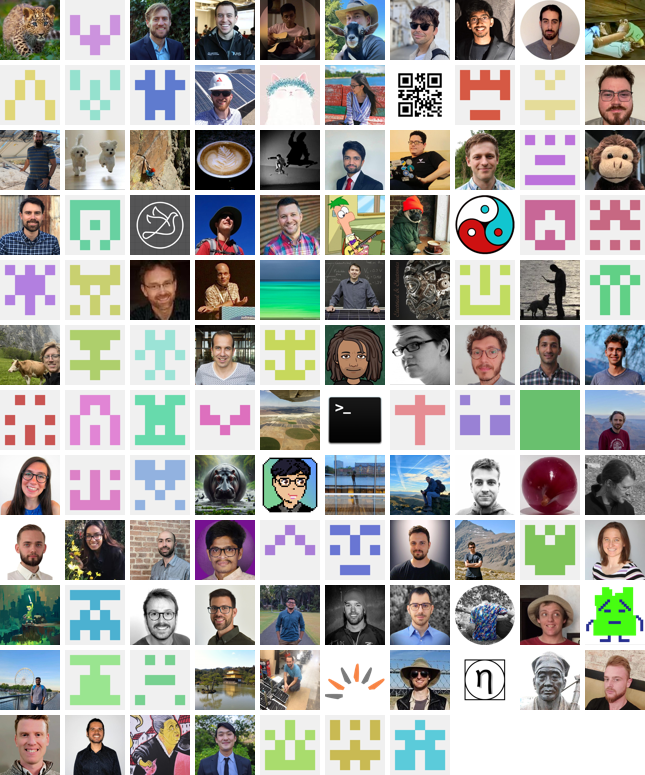

In [18]:
mosaic = utils.make_github_contributors_mosaic(contributor_images)
mosaic